# TIGER nnUnet BatchIterator

In [1]:
## Install latests wholeslidedata
# !pip3 install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main
# !pip3 install lxml

In [2]:
import os
import requests
import yaml
import numpy as np

if os.name == 'nt':
    os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from wholeslidedata.interoperability.nnunet.iterator import WholeSlidePlainnnUnetBatchIterator

# This allows for creating a user config with yaml syntax in a notebook cell
from dicfg.magics import ConfigMagics
ConfigMagics.register_magics()

In [3]:
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"

def convert_path(path, to=current_os):
    if to in ["w", "win", "windows"]:
        path = path.replace("/mnt/pa_cpg", "Y:")
        path = path.replace("/data/pathology", "Z:")
        path = path.replace("/mnt/pa_cpgarchive1", "W:")
        path = path.replace("/mnt/pa_cpgarchive2", "X:")
        path = path.replace("/", "\\")
    if to in ["u", "unix", "l", "linux"]:
        path = path.replace("Y:", "/mnt/pa_cpg")
        path = path.replace("Z:", "/data/pathology")
        path = path.replace("W:", "/mnt/pa_cpgarchive1")
        path = path.replace("X:", "/mnt/pa_cpgarchive2")
        path = path.replace("\\", "/")
    return path

# Table of contents 

1. **User Config**
    - An example user config is give which will be used to configure the batch iterator
2. **BatchIterator**
    - A  BatchIterator is created and some batches are plotted
3. **WholeSlidePlainnnUnetBatchIterator**
    - An example is given how to use the WholeSlidePlainnnUnetBatchIterator to be used in the nnUnet training pipeline
4. **Proposal implementation BatchIterator in nnUNetTrainer**
    - An example **(not tested)** of how the batchiterator **might** can be implemented in the nnUnetTrainer

## 1. **User Config**
- The following yaml will be saved as a dict in 'user_config' with the magic %%yaml                                
- Alternatively, the yaml could be saved in an external user_config.yml file
- Note that this configuration depends on external yaml files: tigersegmentationblissey.yml and augmentations.yml
- Documentation about the syntax in this config can be found here: [dicfg](https://martvanrijthoven.github.io/dicfg/)

**Please check all settings, e.g., the weights in the label sampler, and the augmentations.yml, if they are sensible.**


### 1.1 files yaml

In [4]:
r = requests.get('https://raw.githubusercontent.com/DIAGNijmegen/pathology-whole-slide-data/main/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml')
files_yml = yaml.safe_load(r.text)

In [5]:
first_n_samples = 4
replace_path = '/data/pathology/projects/tiger/new_structure/training/wsirois'

In [6]:
example_files_yaml = {'training':files_yml['training'][0:first_n_samples]}
example_files_yaml
for entry in example_files_yaml['training']:
    entry['wsa']['path'] = convert_path(entry['wsa']['path'].replace('/home/user', replace_path))
    entry['wsi']['path'] = convert_path(entry['wsi']['path'].replace('/home/user', replace_path))
example_files_yaml

{'training': [{'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\100B.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\100B.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\114S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\114S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\122S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\images\\122S.tif'}},
  {'wsa': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\wsirois\\wsi-level-annotations\\annotations-tissue-cells-xmls\\133S.xml'},
   'wsi': {'path': 'Z:\\projects\\tiger\\new_structure\\training\\w

In [7]:
with open('example_files.yml', 'w') as f:
    yaml.dump(example_files_yaml, f)

In [8]:
%%yaml user_config  

wholeslidedata:
    default:
        # Source to data
        yaml_source: example_files.yml 
        
        # Set image backend to asap
        image_backend: asap
                
        # Labels and their value in mask
        labels:
            invasive tumor: 1
            tumor-associated stroma: 2
            in-situ tumor: 3
            healthy glands: 4
            necrosis not in-situ: 5
            inflamed stroma: 6
            rest: 7
            
        # Sort annotations by area (this is how TIGER data is annotated)
        annotation_parser:
            sorters: 
                - ${$wholeslidedata.annotation.selector.sort_by_area_with_roi}
        
        # Batch shape
        batch_shape:
            batch_size: 8
            spacing: 1.0
            shape: [512,512,3]
    
        # Automatically copy files to /home/user/data
        dataset:
            copy_path: 'C:\Users\joeyspronck\Documents\Github\nnUNet_v2\data\nnUNet_wsd' #/home/user/data
    
        # Change labels sampler to WeightedLabelSampler
        label_sampler_name: WeightedLabelSampler
        # The WeightedLabelSampler needs a weight for each label, all weights should sum to 1
        label_sampler:
            labels: 
                invasive tumor: 0.5
                tumor-associated stroma: 0.5
                # in-situ tumor: 0.25
                # healthy glands: 0.05
                # necrosis not in-situ: 0.05
                # inflamed stroma: 0.05
                # rest: 0.35
        
        # Change annotation sampler to AreaAnnotationSampler
        annotation_sampler_name: AreaAnnotationSampler
        # AreaAnnotationSampler, additional needs the dataset as a dependency
        annotation_sampler:
            dataset: ${dataset}
            weight: 0.5  # smooth sampling such that small annotations will be sampled sometimes
        

        batch_callbacks: 
            "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
            sizes: [[256,256], [128,128]]

In [9]:
%%yaml user_config_template  

wholeslidedata:
    default:
        # Source to data
        yaml_source: ''
        
        # Set image backend to asap
        image_backend: asap
                
        # Labels and their value in mask
        labels:
            ''
            
        # Sort annotations by area (this is how TIGER data is annotated)
        annotation_parser:
            sorters: 
                - ${$wholeslidedata.annotation.selector.sort_by_area_with_roi}
        
        # Batch shape
        batch_shape:
            batch_size: ''
            spacing: ''
            shape: ''
    
        # Automatically copy files to /home/user/data
        dataset:
            copy_path: 'C:\Users\joeyspronck\Documents\Github\nnUNet_v2\data\nnUNet_wsd' #/home/user/data
    
        # Change labels sampler to WeightedLabelSampler
        label_sampler_name: WeightedLabelSampler
        # The WeightedLabelSampler needs a weight for each label, all weights should sum to 1
        label_sampler:
            labels: 
#                 invasive tumor: 0.5
#                 tumor-associated stroma: 0.5
                # in-situ tumor: 0.25
                # healthy glands: 0.05
                # necrosis not in-situ: 0.05
                # inflamed stroma: 0.05
                # rest: 0.35
                ''
        
        # Change annotation sampler to AreaAnnotationSampler
        annotation_sampler_name: AreaAnnotationSampler
        # AreaAnnotationSampler, additional needs the dataset as a dependency
        annotation_sampler:
            dataset: ${dataset}
            weight: 0.5  # smooth sampling such that small annotations will be sampled sometimes
        

        batch_callbacks: 
            "*object": wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback
            sizes: ''

### Display user_config

In [10]:
user_config

{'wholeslidedata': {'default': {'yaml_source': 'example_files.yml',
   'image_backend': 'asap',
   'labels': {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7},
   'annotation_parser': {'sorters': ['${$wholeslidedata.annotation.selector.sort_by_area_with_roi}']},
   'batch_shape': {'batch_size': 8, 'spacing': 1.0, 'shape': [512, 512, 3]},
   'dataset': {'copy_path': 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'},
   'label_sampler_name': 'WeightedLabelSampler',
   'label_sampler': {'labels': {'invasive tumor': 0.5,
     'tumor-associated stroma': 0.5}},
   'annotation_sampler_name': 'AreaAnnotationSampler',
   'annotation_sampler': {'dataset': '${dataset}', 'weight': 0.5},
   'batch_callbacks': {'*object': 'wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback',
    'sizes': [[256, 256], [128, 128]]}}}}

In [11]:
user_config_template

{'wholeslidedata': {'default': {'yaml_source': '',
   'image_backend': 'asap',
   'labels': '',
   'annotation_parser': {'sorters': ['${$wholeslidedata.annotation.selector.sort_by_area_with_roi}']},
   'batch_shape': {'batch_size': '', 'spacing': '', 'shape': ''},
   'dataset': {'copy_path': 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'},
   'label_sampler_name': 'WeightedLabelSampler',
   'label_sampler': {'labels': ''},
   'annotation_sampler_name': 'AreaAnnotationSampler',
   'annotation_sampler': {'dataset': '${dataset}', 'weight': 0.5},
   'batch_callbacks': {'*object': 'wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback',
    'sizes': ''}}}}

In [12]:
yaml_source = 'example_files.yml'
labels = {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7}
batch_size = 15
patch_size = [512, 512]
patch_shape = [512, 512, 3]
spacing = 0.5
label_sample_weights = {
    'invasive tumor': 0.5,
    'tumor-associated stroma': 0.5
}
ds_scales = [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125], [0.015625, 0.015625]]
ds_shapes = [list(np.round([int(i * j) for i, j in zip(patch_size, k)])) for k in ds_scales]
extra_ds_sizes = [ds_shape for ds_shape in ds_shapes[1:]]
extra_ds_shapes = tuple([tuple([batch_size]+ds_shape) for ds_shape in ds_shapes[1:]])

In [13]:
fill_template = user_config_template['wholeslidedata']['default']

fill_template['yaml_source'] = yaml_source
fill_template['labels'] = labels
fill_template['batch_shape']['batch_size'] = batch_size
fill_template['batch_shape']['spacing'] = spacing
fill_template['batch_shape']['shape'] = patch_shape
fill_template['label_sampler']['labels'] = label_sample_weights
fill_template['batch_callbacks']['sizes'] = extra_ds_sizes

In [14]:
user_config_template

{'wholeslidedata': {'default': {'yaml_source': 'example_files.yml',
   'image_backend': 'asap',
   'labels': {'invasive tumor': 1,
    'tumor-associated stroma': 2,
    'in-situ tumor': 3,
    'healthy glands': 4,
    'necrosis not in-situ': 5,
    'inflamed stroma': 6,
    'rest': 7},
   'annotation_parser': {'sorters': ['${$wholeslidedata.annotation.selector.sort_by_area_with_roi}']},
   'batch_shape': {'batch_size': 15, 'spacing': 0.5, 'shape': [512, 512, 3]},
   'dataset': {'copy_path': 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_wsd'},
   'label_sampler_name': 'WeightedLabelSampler',
   'label_sampler': {'labels': {'invasive tumor': 0.5,
     'tumor-associated stroma': 0.5}},
   'annotation_sampler_name': 'AreaAnnotationSampler',
   'annotation_sampler': {'dataset': '${dataset}', 'weight': 0.5},
   'batch_callbacks': {'*object': 'wholeslidedata.samplers.callbacks.DeepSupervisionBatchCallback',
    'sizes': [[256, 256], [128, 128], [64, 64], [32, 32], [16, 1

## 2. **Batch Iterator**

- First time calling create_batch_iterator will copy all the images and annotations. This can take a while when using the full tiger training dataset.
- Second time calling create_batch_iterator will skip copying as it will already find the local files.
- Each time calling create_batch_iterator will initialize the TIGER training dataset; this can take up to 2 minutes when using the full tiger training dataset.

In [15]:
cpus = 4
tiger_batch_iterator = create_batch_iterator(mode="training", 
                                             user_config=user_config_template, 
                                             cpus=cpus, 
                                             buffer_dtype='uint8',
                                             context='spawn',
                                             extras_shapes = extra_ds_shapes
                                            )

### Plot batches

In [16]:
# for i in range(2):
#     x_batch, y_batch, info =  next(tiger_batch_iterator)
#     plot_batch(x_batch, y_batch, alpha=0.3)

In [17]:
x_batch, y_batch, *extras, info =  next(tiger_batch_iterator)


KeyboardInterrupt



# BELOW IS OLD NOW

In [13]:
import numpy as np
import torch
from skimage.transform import resize
import matplotlib.pyplot as plt

#### Dummy example

In [15]:
batch_size = 2
patch_size = [512, 512]
device = torch.device('cuda')
dummy_data = torch.rand((batch_size, 3, *patch_size), device=device)
dummy_target = [
    torch.round(
        torch.rand((batch_size, 1, *[int(i * j) for i, j in zip(patch_size, k)]), device=device) *
        max(all_labels)
    ) for k in deep_supervision_scales]

In [16]:
dummy_data.shape

torch.Size([2, 3, 512, 512])

In [17]:
for i in dummy_target:
    print(i.shape)

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 128, 128])
torch.Size([2, 1, 64, 64])
torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 16, 16])


#### How to get the deep supervision shapes

#### Resize example

In [78]:
def resize_segmentation(segmentation, new_shape, order=3):
    '''
    Resizes a segmentation map. Supports all orders (see skimage documentation). Will transform segmentation map to one
    hot encoding which is resized and transformed back to a segmentation map.
    This prevents interpolation artifacts ([0, 0, 2] -> [0, 1, 2])
    :param segmentation:
    :param new_shape:
    :param order:
    :return:
    '''
    tpe = segmentation.dtype
    unique_labels = np.unique(segmentation)
    assert len(segmentation.shape) == len(new_shape), "new shape must have same dimensionality as segmentation"
    if order == 0:
        return resize(segmentation.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False).astype(tpe)
    else:
        reshaped = np.zeros(new_shape, dtype=segmentation.dtype)

        for i, c in enumerate(unique_labels):
            mask = segmentation == c
            reshaped_multihot = resize(mask.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False)
            reshaped[reshaped_multihot >= 0.5] = c
        return reshaped

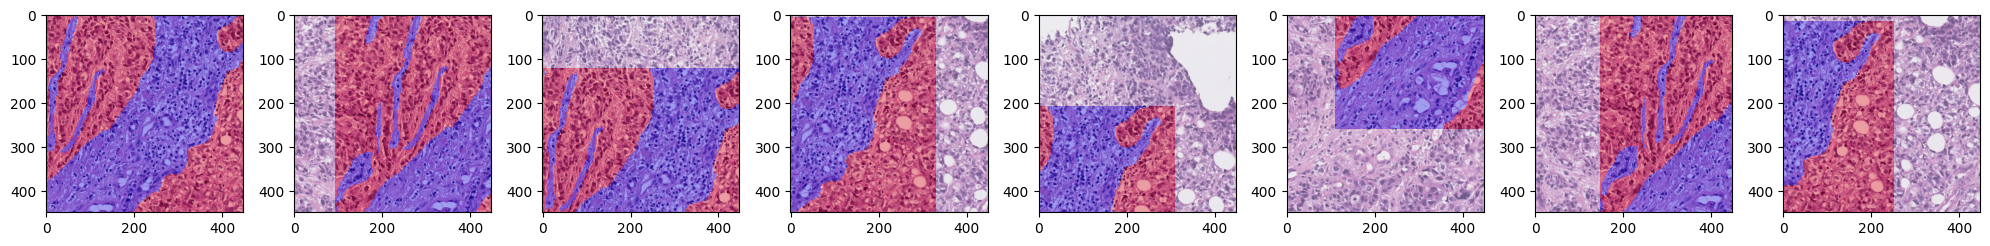

In [126]:
x_batch, y_batch, info =  next(tiger_batch_iterator)
plot_batch(x_batch, y_batch, alpha=0.3)

In [ ]:
import timeit

[8, 448, 448]


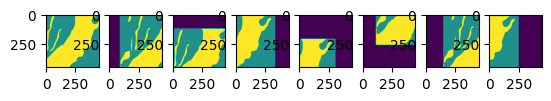


[8, 224, 224]


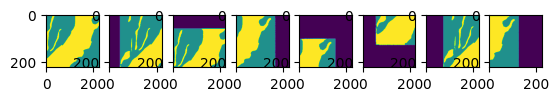


[8, 112, 112]


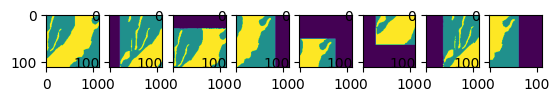


[8, 56, 56]


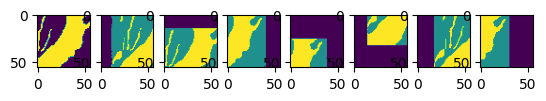


[8, 28, 28]


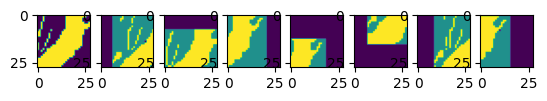


[8, 14, 14]


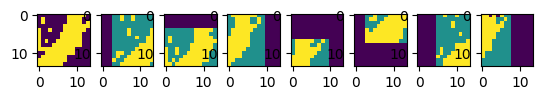

In [156]:
bs = y_batch.shape[0]
for ds_shape in ds_shapes:
    resized_batch = resize_segmentation(y_batch, [bs] + ds_shape)
    print([bs] + ds_shape)
    
    fig, axs = plt.subplots(1, bs)
    for i in range(bs):
        axs[i].imshow(resized_batch[i])
    plt.show()
    print()

In [158]:
ds_shapes

[[448, 448], [224, 224], [112, 112], [56, 56], [28, 28], [14, 14]]

In [159]:
import time

start_time = time.time()

for ds_shape in ds_shapes:
    resized_batch = resize_segmentation(y_batch, [bs] + ds_shape)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 5.7554 seconds


In [160]:
import time

start_time = time.time()

resized_batches = [resize_segmentation(y_batch, [bs] + ds_shape) for ds_shape in ds_shapes]

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 5.7672 seconds


In [130]:
resized_batch.shape

(8, 56, 56)

## Stop the iterator to free up all memory

In [130]:
tiger_batch_iterator.stop()

## 3. **WholeSlidePlainnnUnetBatchIterator**

The WholeSlidennUnetBatchIterator is a wrapper around the default Batchiterator, it does the following things:

- tranpose x_batch to channels first
- convert dtype of x_batch to float32
- convert dtype of y_batch to int16
- returns dictionary with keys: 'data', 'target'  for x_batch and y_batch, respectively

In [8]:
cpus = 4
nnunet_tiger_batch_iterator = create_batch_iterator(mode="training", 
                                                    user_config=user_config, 
                                                    cpus=cpus, 
                                                    buffer_dtype='uint8', 
                                                    iterator_class=WholeSlidePlainnnUnetBatchIterator) # here we can set the WholeSlidennUnetBatchIterator wrapper 

In [9]:
# get next batch for training nnunet
batch = next(nnunet_tiger_batch_iterator)
data = batch['data']
target = batch['seg_all']

# check shape and dtypes
print('data:\t', data.shape, data.dtype)
print('target:\t', target.shape, target.dtype)

data:	 (8, 3, 512, 512) float32
target:	 (8, 512, 512) int16


In [10]:
nnunet_tiger_batch_iterator.stop()

## **(NOT TESTED) Proposal implementation BatchIterator in nnUNetTrainer**

I think there are two ways of implementing the WholeSlideData batchiterator in the nnUnet pipeline.

1. overriding the 'get_plain_dataloaders' method
2. overriding the 'get_dataloaders' method

### 1. Overriding the 'get_plain_dataloaders' method
This has the advantageous that (I think) it works out of the box and an example implementation is shown below. However I have not tested it and I might have missed something. The downside is that both nnUnet as well as the batchiterator utilizes multiprocessing. This however might not be a problem if you divide cpus between the batchiterator and nnunet pipeline, e.g., 6 to the iterator and 6 for the nnunet pipeline.

In [15]:
class WholeSlidennUNetTrainer(nnUNetTrainer):
    def __init__(self, 
                 plans: dict, 
                 configuration: str, 
                 fold: int, 
                 dataset_json: dict, 
                 iterator_config: Union[str, path, dict],
                 iterator_cpus: int,
                 unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        
        self._iterator_config = iterator_config
        self._iterator_cpus = iterator_cpus
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        
        
    def get_plain_dataloaders(self):
        dl_tr = create_batch_iterator(mode="training", 
                                      user_config=self._iterator_config, 
                                      cpus=self._iterator_cpus, 
                                      buffer_dtype='uint8', 
                                      iterator_class=WholeSlidePlainnnUnetBatchIterator) 
        
        dl_val = create_batch_iterator(mode="validation",
                                       user_config=self._iterator_config, 
                                       cpus=self._iterator_cpus, 
                                       buffer_dtype='uint8', 
                                       iterator_class=WholeSlidePlainnnUnetBatchIterator) 
        return dl_tr, dl_val

NameError: name 'nnUNetTrainer' is not defined

### 2. Overriding the 'get_dataloaders' method
This has the advantageous that all multiprocessing can be done via the BatchIterator. The downside is that some essential transforms, e.g., DownsampleSegForDSTransform2 for deep supervision should be done via batch callbacks in the BatchIterator. This can be done, but is not super straightforward and I have not made an example for this (yet).

# Recreate the init in the train loop

In [1]:
import torch
from nnunetv2.training.nnUNetTrainer.variants.pathology.nnUNetTrainer_custom_dataloader_test import nnUNetTrainer_custom_dataloader_test 
from batchgenerators.utilities.file_and_folder_operations import join, isfile, load_json

In [2]:
plans_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset001_local_test\\nnUNetPlans.json'
configuration = '2d'
fold = 0
dataset_json_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset001_local_test\\dataset.json'
use_compressed = False
device = torch.device('cuda')

plans = load_json(plans_file)
dataset_json = load_json(dataset_json_file)

### Below I proved the default plans file works

In [3]:
# nnunet_trainer = nnUNetTrainer_custom_dataloader_test
# nnunet_trainer = nnunet_trainer(plans=plans, configuration=configuration, fold=fold,
#                                 dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

In [4]:
# nnunet_trainer.run_training()

# Now remove as much as possible from plans

In [2]:
# plans

In [22]:
dataset_json

{'channel_names': {'0': 'rgb_to_0_1', '1': 'rgb_to_0_1', '2': 'rgb_to_0_1'},
 'labels': {'background': 0,
  'tumor': 1,
  'none': 2,
  'stroma': 3,
  'inflammation': 4,
  'healthy parenchyma': 5,
  'fatty tissue': 6,
  'necrotic tissue': 7,
  'erytrocytes': 8,
  'healthy epithelium': 9,
  'mucus': 10,
  'cartilage': 11,
  'macrophages': 12,
  'other': 13},
 'numTraining': 163,
 'file_ending': '.png'}

In [21]:
plans_essential = {
    # plans_name
    'plans_name': 'nnUNetPlans',
    # dataset_name
    'dataset_name': 'Dataset002_plain_test', # only needed for name of output folder
    # configurations
    'configurations': {'2d': {'data_identifier': 'nnUNetPlans_2d',
    'preprocessor_name': 'DefaultPreprocessor',
    'batch_size': 16,
    'patch_size': [448, 448],
#     'median_image_size_in_voxels': [1022.0, 1032.0],
#     'spacing': [1.0, 1.0],
    'normalization_schemes': ['RGBTo01Normalization',
    'RGBTo01Normalization',
    'RGBTo01Normalization'],
#     'use_mask_for_norm': [False, False, False],
    'UNet_class_name': 'PlainConvUNet',
    'UNet_base_num_features': 32,
    'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2, 2],
    'n_conv_per_stage_decoder': [2, 2, 2, 2, 2, 2],
    'num_pool_per_axis': [6, 6],
    'pool_op_kernel_sizes': [[1, 1],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2],
    [2, 2]],
    'conv_kernel_sizes': [[3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3],
    [3, 3]],
    'unet_max_num_features': 512,
#     'resampling_fn_data': 'resample_data_or_seg_to_shape',
#     'resampling_fn_seg': 'resample_data_or_seg_to_shape',
#     'resampling_fn_data_kwargs': {'is_seg': False,
#     'order': 3,
#     'order_z': 0,
#     'force_separate_z': None},
#     'resampling_fn_seg_kwargs': {'is_seg': True,
#     'order': 1,
#     'order_z': 0,
#     'force_separate_z': None},
#     'resampling_fn_probabilities': 'resample_data_or_seg_to_shape',
#     'resampling_fn_probabilities_kwargs': {'is_seg': False,
#     'order': 1,
#     'order_z': 0,
#     'force_separate_z': None},
    'batch_dice': True
                             }}
}

In [19]:
nnunet_trainer = nnUNetTrainer_custom_dataloader_test
nnunet_trainer = nnunet_trainer(plans=plans_essential, configuration=configuration, fold=fold,
                                dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

Using device: cuda:0
No label manager specified in plans. Using default: LabelManager

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Making summy data
	patch size: [448, 448]
	self.label_manager.all_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	self._get_deep_supervision_scales() [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125]]


In [16]:
nnunet_trainer.run_training()

# New experiment planner

In [5]:
plans_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset003_plain_experiment_planning\\nnUNetWholeSlideDataPlans.json'
configuration = '2d'
fold = 0
dataset_json_file = 'C:\\Users\\joeyspronck\\Documents\\Github\\nnUNet_v2\\data\\nnUNet_preprocessed\\Dataset003_plain_experiment_planning\\dataset.json'
use_compressed = False
device = torch.device('cuda')

wsd_plans = load_json(plans_file)
dataset_json = load_json(dataset_json_file)

In [6]:
nnunet_trainer = nnUNetTrainer_custom_dataloader_test
nnunet_trainer = nnunet_trainer(plans=wsd_plans, configuration=configuration, fold=fold,
                                dataset_json=dataset_json, unpack_dataset=not use_compressed, device=device)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Making summy data
	patch size: [512, 512]
	self.label_manager.all_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
	self._get_deep_supervision_scales() [[1.0, 1.0], [0.5, 0.5], [0.25, 0.25], [0.125, 0.125], [0.0625, 0.0625], [0.03125, 0.03125], [0.015625, 0.015625]]


In [17]:
nnunet_trainer.run_training()


This is the configuration used by this training:
Configuration name: 2d
 {'data_identifier': 'nnUNetWholeSlideDataPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 15, 'patch_size': [512, 512], 'median_image_size_in_voxels': [1024, 1024], 'spacing': [1, 1], 'normalization_schemes': ['RGBTo01Normalization', 'RGBTo01Normalization', 'RGBTo01Normalization'], 'use_mask_for_norm': [False, False, False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2, 2, 2], 'num_pool_per_axis': [7, 7], 'pool_op_kernel_sizes': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'unet_max_num_features': 512, 'batch_dice': True} 

These are the global plan.json settings:
 {'dataset_name': 'Dataset003_plain_experiment_planning', 'plans_name': 'nnUNetWholeSlideDataPlans', 'image_r

# Make dummy batch

In [16]:
nnunet_trainer.dummy_batch['data'].shape

torch.Size([2, 3, 448, 448])

In [27]:
for i in range(6):
    print('ds', i, ':',  nnunet_trainer.dummy_batch['target'][i].shape)

ds 0 : torch.Size([2, 1, 448, 448])
ds 1 : torch.Size([2, 1, 224, 224])
ds 2 : torch.Size([2, 1, 112, 112])
ds 3 : torch.Size([2, 1, 56, 56])
ds 4 : torch.Size([2, 1, 28, 28])
ds 5 : torch.Size([2, 1, 14, 14])
